In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00


# Libraries

In [2]:
import os
import cv2
import glob
import torch
import shutil
import random
import numpy as np
from tqdm import tqdm
from lxml import etree as ET
import albumentations as A
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Folder Creation

In [3]:
train_dir= "/content/drive/MyDrive/Data/Train"
test_dir= "/content/drive/MyDrive/Data/Test"

temp_dir= "/content/yolo_data"
os.makedirs(f"{temp_dir}/images/train", exist_ok=True)
os.makedirs(f"{temp_dir}/images/valid", exist_ok=True)
os.makedirs(f"{temp_dir}/images/test", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/train", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/valid", exist_ok=True)
os.makedirs(f"{temp_dir}/labels/test", exist_ok=True)

# Train/Valid Split

In [10]:
image_paths=glob.glob(f"{train_dir}/*.jpg")
random.shuffle(image_paths)

train_files=image_paths[:int(0.85*len(image_paths))]
valid_files=image_paths[int(0.85*len(image_paths)):]

def split_data(files_range,loc,mode):
  for img_path in tqdm(files_range):
    os.makedirs(f"{loc}/temp/{mode}", exist_ok=True)
    img_name=os.path.basename(img_path)
    label_path=img_path.replace('/images','/labels').replace(".jpg",".xml")

    shutil.copy(img_path,f"{loc}/temp/{mode}/{img_name}")
    shutil.copy(label_path,f"{loc}/temp/{mode}/{img_name.replace(".jpg",".xml")}")

In [11]:
list=[0,0,0,0]
for files in train_files:
  if "apple" in files:
    list[0]+=1
  if "banana" in files:
    list[1]+=1
  if "orange" in files:
    list[2]+=1
  if "mixed" in files:
    list[3]+=1
print(list)

[61, 64, 61, 18]


In [12]:
split_data(train_files,f"{temp_dir}","train")
split_data(valid_files,f"{temp_dir}","valid")

100%|██████████| 36/36 [00:00<00:00, 112.08it/s]


# Data Annotation

## Annotation Function

In [13]:
def xml_yolo_format(xml_file,height,width):
  tree= ET.parse(xml_file)
  root= tree.getroot()

  yolo_annotations=[]

  for obj in root.findall("object"):
    name= obj.find("name").text
    id={'apple':0, 'banana':1, 'orange':2}[name]
    xmin= int(obj.find("bndbox/xmin").text)
    xmax= int(obj.find("bndbox/xmax").text)
    ymin= int(obj.find("bndbox/ymin").text)
    ymax= int(obj.find("bndbox/ymax").text)

    x_center=(xmin+xmax)/2/width
    y_center=(ymin+ymax)/2/height
    width_box=(xmax-xmin)/width
    height_box=(ymax-ymin)/height

    yolo_annotations.append(f"{id} {x_center} {y_center} {width_box} {height_box}")
  return yolo_annotations


## File Conversion Function

In [14]:
def xml_to_yolo(xml_file_path, mode):
  xml_paths=glob.glob(os.path.join(xml_file_path,'*.xml'))

  for xml_path in xml_paths:
    img_path=xml_path.replace('xml','jpg')
    txt_path=xml_path.replace('xml','txt')

    img=cv2.imread(img_path)
    x,y,_=img.shape
    yolo_annotations=xml_yolo_format(xml_path,x,y)

    out_img_path=f"{temp_dir}/images/{mode}/{os.path.basename(img_path)}"
    cv2.imwrite(out_img_path,img)

    out_txt_path=f"{temp_dir}/labels/{mode}/{os.path.basename(txt_path)}"
    with open(out_txt_path,'w') as f:
      f.write('\n'.join(yolo_annotations))

In [15]:
xml_to_yolo(f"{temp_dir}/temp/train","train")
xml_to_yolo(f"{temp_dir}/temp/valid","valid")
xml_to_yolo(test_dir,"test")

# Data Preprocessing

In [16]:
#Augmentation
transform=A.Compose(
    [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
    A.ColorJitter(p=0.3)
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

#Transformation
img_paths=glob.glob(f"{temp_dir}/images/train/*.jpg")
for img_path in img_paths:
  txt_path=img_path.replace("/images","/labels").replace(".jpg",".txt")

  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  with open (txt_path,"r") as f:
    lines=f.readlines()
    labels=[]
    bbox=[]

    for line in lines:
      c,x,y,w,h=map(float, line.split())
      labels.append(int(c))
      bbox.append([x,y,w,h])

  transformed=transform(image=img, bboxes=bbox, class_labels=labels)
  new_img=transformed['image']
  new_bbox=transformed['bboxes']
  new_labels=transformed['class_labels']

  #Saving
  cv2.imwrite(img_path,cv2.cvtColor(new_img,cv2.COLOR_RGB2BGR))

  with open (txt_path,'w') as f:
    for labels,bboxs in zip(new_labels,new_bbox):
      x,y,w,h=bboxs
      f.write(f"{labels} {x} {y} {w} {h} \n")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
#Augmentation For Banana Images
transform=A.Compose(
    [
    A.RandomBrightnessContrast(p=0.4),
    A.ColorJitter(p=0.3),
    A.GaussianBlur(p=0.2),
    A.MotionBlur(p=0.2),
    A.RandomShadow(p=0.2)
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

#Seperation of Banana Images
img_paths=glob.glob(f"{temp_dir}/images/train/*.jpg")
list2=[]
for files in img_paths:
  if "banana" in files:
    list2.append(files)

#Transformation
for img_path in list2:
  txt_path=img_path.replace("/images","/labels").replace(".jpg",".txt")

  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  with open (txt_path,"r") as f:
    lines=f.readlines()
    labels=[]
    bbox=[]

    for line in lines:
      c,x,y,w,h=map(float, line.split())
      labels.append(int(c))
      bbox.append([x,y,w,h])

  transformed=transform(image=img, bboxes=bbox, class_labels=labels)
  new_img=transformed['image']
  new_bbox=transformed['bboxes']
  new_labels=transformed['class_labels']

  #Saving
  cv2.imwrite(img_path,cv2.cvtColor(new_img,cv2.COLOR_RGB2BGR))

  with open (txt_path,'w') as f:
    for labels,bboxs in zip(new_labels,new_bbox):
      x,y,w,h=bboxs
      f.write(f"{labels} {x} {y} {w} {h} \n")


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


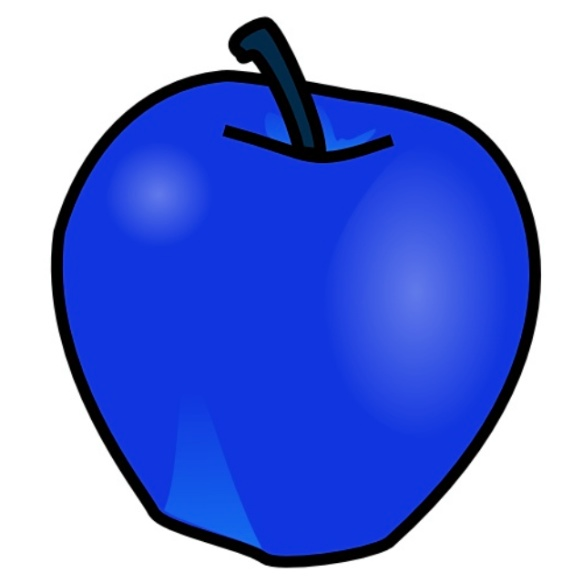

In [ ]:
#Sample Image
from google.colab.patches import cv2_imshow
img_pa=glob.glob("/content/yolo_dataset/images/train_aug/*.jpg")
img_pat=random.choice(img_pa)
img=cv2.imread(img_pat)
cv2_imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# Yaml File Creation

In [21]:
yaml_file="""
train: /content/yolo_data/images/train
val: /content/yolo_data/images/valid
nc: 3
names: ["apple", "banana", "orange"]
"""
with open("/content/yolo_data/data.yaml","w") as f:
  f.write(yaml_file)

# Model Training

In [19]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model=YOLO("yolov8s.pt")
model.train(
    data="/content/yolo_data/data.yaml",
    epochs=80,
    batch=8,
    patience=15,
    device=device
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7894906632f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Model Validation

In [23]:
metrics=model.val(data="/content/yolo_data/data.yaml",
                   device=0)
print(metrics)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1371.3±1002.3 MB/s, size: 159.9 KB)
val: Scanning /content/yolo_data/labels/valid.cache... 36 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 36/36 33.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.4it/s 2.1s
                   all         36         63      0.971      0.892      0.962      0.717
                 apple         15         25      0.952       0.96      0.989      0.828
                banana         11         23      0.981      0.783      0.927       0.54
                orange         13         15      0.981      0.933      0.971      0.784
Speed: 9.2ms preprocess, 25.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.

## Metrics

In [35]:
print("Precision : ", metrics.box.p)
print("Recall    : ", metrics.box.r)
print("F1        : ", metrics.box.f1)
print("mAP50     : ", metrics.box.map50)
print("mAP50-95  : ", metrics.box.map)
print("Confusion matrix: \n", metrics.confusion_matrix.matrix)

Precision :  [    0.95194     0.98054     0.98089]
Recall    :  [       0.96     0.78261     0.93333]
F1        :  [    0.95595     0.87047     0.95652]
mAP50     :  0.9623740960917017
mAP50-95  :  0.7171359897507459
Confusion matrix: 
 [[         24           0           0           1]
 [          0          21           1           7]
 [          1           0          14           0]
 [          0           2           0           0]]


# Model Testing

In [36]:
result=model.predict(source="/content/yolo_data/images/test",
                     save=True,
                    device=device)


image 1/60 /content/yolo_data/images/test/apple_77.jpg: 512x640 4 apples, 61.7ms
image 2/60 /content/yolo_data/images/test/apple_78.jpg: 640x640 1 apple, 17.0ms
image 3/60 /content/yolo_data/images/test/apple_79.jpg: 640x640 1 orange, 16.2ms
image 4/60 /content/yolo_data/images/test/apple_80.jpg: 544x640 1 apple, 47.0ms
image 5/60 /content/yolo_data/images/test/apple_81.jpg: 640x576 1 apple, 47.4ms
image 6/60 /content/yolo_data/images/test/apple_82.jpg: 640x576 1 apple, 15.8ms
image 7/60 /content/yolo_data/images/test/apple_83.jpg: 608x640 1 apple, 51.8ms
image 8/60 /content/yolo_data/images/test/apple_84.jpg: 448x640 6 apples, 49.0ms
image 9/60 /content/yolo_data/images/test/apple_85.jpg: 512x640 2 apples, 13.9ms
image 10/60 /content/yolo_data/images/test/apple_86.jpg: 448x640 4 apples, 13.4ms
image 11/60 /content/yolo_data/images/test/apple_87.jpg: 640x640 1 apple, 17.2ms
image 12/60 /content/yolo_data/images/test/apple_88.jpg: 640x640 1 apple, 1 banana, 16.2ms
image 13/60 /content/

In [60]:
#Sample Bounding Box Details
for r in result:
  for box in r.boxes:
    print("Class :", int(box.cls[0]))
    print("Conf  :", float(box.conf[0]))
    print("XYXY  :", box.xyxy[0].tolist())
    print("XYWH  :", box.xywh[0].tolist())
    print("-----")
  break

Class : 0
Conf  : 0.9041740894317627
XYXY  : [104.0224380493164, 125.08268737792969, 215.7908935546875, 227.45494079589844]
XYWH  : [159.9066619873047, 176.26881408691406, 111.7684555053711, 102.37225341796875]
-----
Class : 0
Conf  : 0.8724905252456665
XYXY  : [210.50143432617188, 141.8721466064453, 299.6773986816406, 228.15545654296875]
XYWH  : [255.08941650390625, 185.0137939453125, 89.17596435546875, 86.28330993652344]
-----
Class : 0
Conf  : 0.8252105712890625
XYXY  : [68.3471450805664, 54.19478225708008, 174.6822967529297, 167.61148071289062]
XYWH  : [121.51472473144531, 110.90312957763672, 106.33515167236328, 113.41670227050781]
-----
Class : 0
Conf  : 0.594211995601654
XYXY  : [3.598823308944702, 16.211885452270508, 106.9876480102539, 143.20570373535156]
XYWH  : [55.293235778808594, 79.70879364013672, 103.38882446289062, 126.99382019042969]
-----


# Visualization

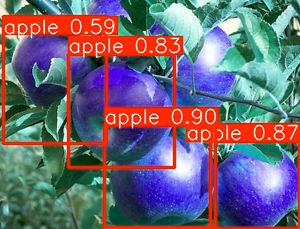

In [63]:
from google.colab.patches import cv2_imshow
img_pa=glob.glob("/content/runs/detect/predict/*.jpg")
img_pat=random.choice(img_pa)
img=cv2.imread(img_pat)
cv2_imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))